In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("/Users/benjamin/Downloads/makemore-master/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [352]:
# build data set
block_size = 3
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape, X.dtype, Y.dtype)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182484, 3]) torch.Size([182484]) torch.int64 torch.int64
torch.Size([22869, 3]) torch.Size([22869]) torch.int64 torch.int64
torch.Size([22793, 3]) torch.Size([22793]) torch.int64 torch.int64


In [353]:
# ------------ now made respectable :) ---------------

In [369]:
emb_dims = 10
hidden_layers = 200
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dims), generator=g)
W1 = torch.randn((block_size * emb_dims, hidden_layers), generator=g) * (5/3) * (block_size * emb_dims)**0.5
b1 = torch.randn(hidden_layers, generator=g) * 0.01
W2 = torch.randn((hidden_layers, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

In [370]:
sum(p.nelement() for p in parameters)

11897

In [371]:
for p in parameters:
    p.requires_grad=True

In [372]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [373]:
lri = []
lossi = []
stepi = []

In [376]:
max_steps = 200000
batch_size = 32

# forward pass
for i in range(max_steps):
    # mini batch, basically don't do all the neuron training but small batch every iteration.
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    emb = C[Xtr[ix]]
    # hidden layer
    h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
print(loss.item())    


      0/ 200000: 3.3395
  10000/ 200000: 2.2738
  20000/ 200000: 2.2409
  30000/ 200000: 2.4512
  40000/ 200000: 2.5880
  50000/ 200000: 2.6790
  60000/ 200000: 2.1327
  70000/ 200000: 2.1788
  80000/ 200000: 2.0733
  90000/ 200000: 2.5003
 100000/ 200000: 2.7456
 110000/ 200000: 1.9240
 120000/ 200000: 2.2716
 130000/ 200000: 2.3295
 140000/ 200000: 1.9787
 150000/ 200000: 1.8582
 160000/ 200000: 2.2506
 170000/ 200000: 2.0363
 180000/ 200000: 2.6012
 190000/ 200000: 1.9651
1.900206208229065


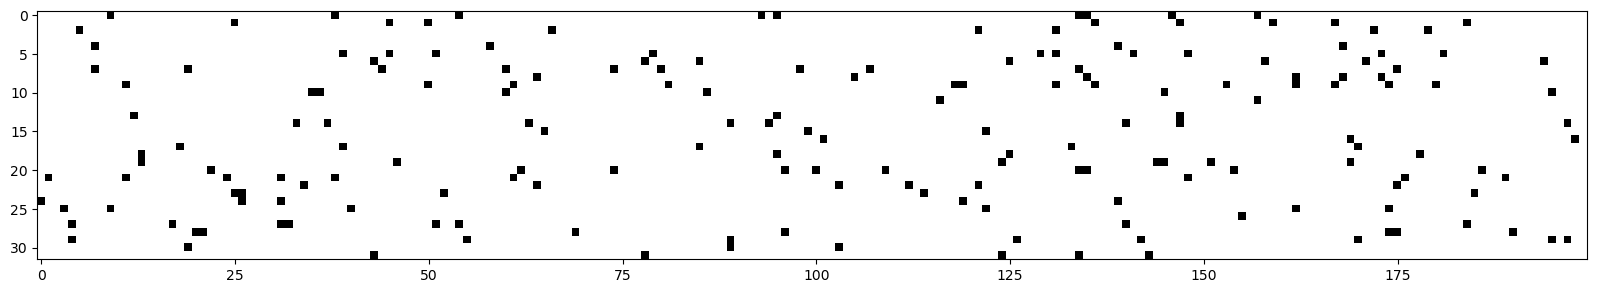

In [368]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [377]:
emb = C[Xtr]
# hidden layer
h = torch.tanh(emb.view(-1, block_size*emb_dims) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1759, grad_fn=<NllLossBackward0>)

In [378]:
emb = C[Xdev]
# hidden layer
h = torch.tanh(emb.view(-1, block_size*emb_dims) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2139, grad_fn=<NllLossBackward0>)

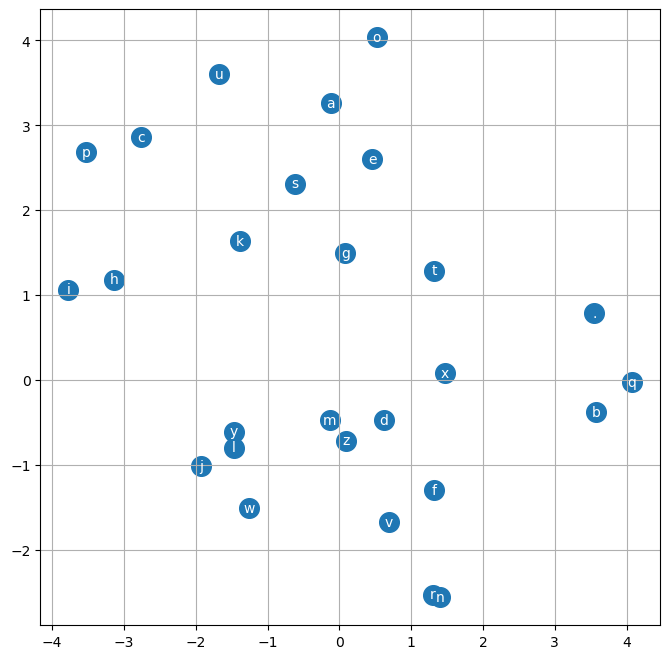

In [379]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [380]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
kayannieen.
ndyn.
alarethrai.
jarlen.
adelynnelin.
shi.
jen.
eden.
estanar.
kayziohlte.
cayshabergiagmiest.
jaireelynn.
novalyn.
brence.
ryyah.
fiel.
yuma.
miston.
azhil.


In [381]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [383]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1760754585266113
val 2.21405029296875
